C:\Users\vishal kumar\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\vishal kumar\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Train Loss=1.0242, Acc=0.6264 | Val Loss=0.9307, Acc=0.6642
Epoch 2: Train Loss=0.8686, Acc=0.6723 | Val Loss=0.9302, Acc=0.6479
Epoch 3: Train Loss=0.8221, Acc=0.6836 | Val Loss=0.7852, Acc=0.6860
Epoch 4: Train Loss=0.7992, Acc=0.6945 | Val Loss=0.7699, Acc=0.6751
Epoch 5: Train Loss=0.7763, Acc=0.7064 | Val Loss=0.7604, Acc=0.7042
Epoch 6: Train Loss=0.7090, Acc=0.7227 | Val Loss=0.7101, Acc=0.7005
Epoch 7: Train Loss=0.6864, Acc=0.7355 | Val Loss=0.6815, Acc=0.7368
Epoch 8: Train Loss=0.6698, Acc=0.7373 | Val Loss=0.7186, Acc=0.7260
Epoch 9: Train Loss=0.6653, Acc=0.7377 | Val Loss=0.6899, Acc=0.7387
Epoch 10: Train Loss=0.6571, Acc=0.7432 | Val Loss=0.7363, Acc=0.7151
Epoch 11: Train Loss=0.6342, Acc=0.7455 | Val Loss=0.6801, Acc=0.7532
Epoch 12: Train Loss=0.6200, Acc=0.7623 | Val Loss=0.6757, Acc=0.7387
Epoch 13: Train Loss=0.6024, Acc=0.7582 | Val Loss=0.6732, Acc=0.7604
Epoch 14: Train Loss=0.6038, Acc=0.7691 | Val Loss=0.6639, Acc=0.7532
Epoch 15: Train Loss=0.5898, 

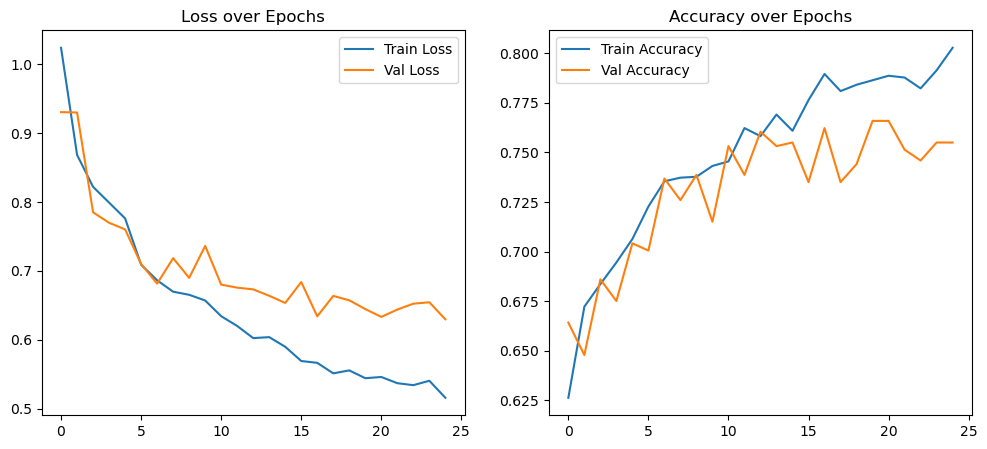


Classification Report:
                precision    recall  f1-score   support

       Healthy       0.96      0.98      0.97       204
       Mild DR       0.59      0.63      0.61        78
   Moderate DR       0.69      0.78      0.73       179
Proliferate DR       0.58      0.35      0.44        51
     Severe DR       0.48      0.33      0.39        39

      accuracy                           0.76       551
     macro avg       0.66      0.61      0.63       551
  weighted avg       0.75      0.76      0.75       551



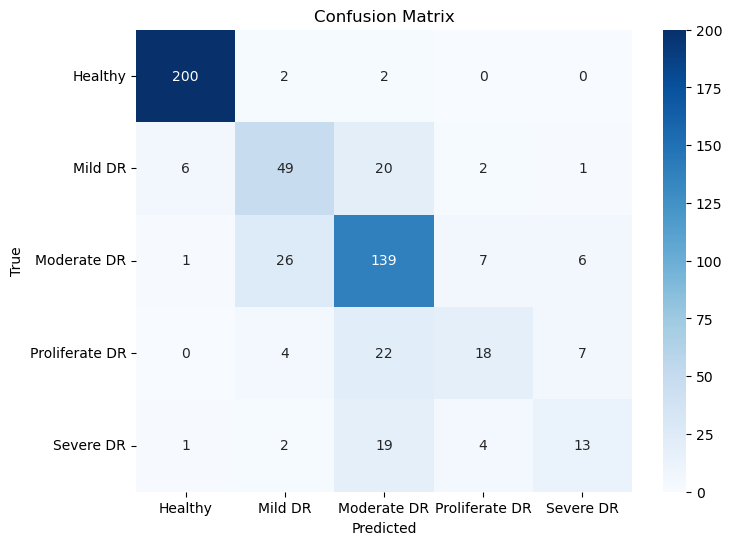

Predicted Class: Severe DR


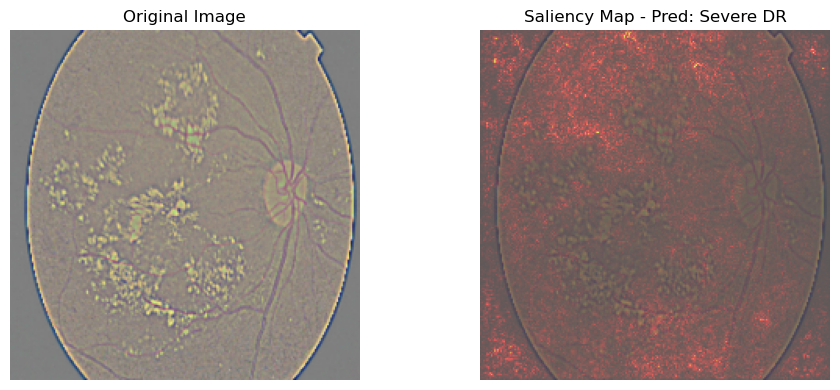

In [1]:
#code 2 better saliency map
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from PIL import Image
import numpy as np

# Paths
data_dir = r"C:\Users\vishal kumar\Desktop\dataset\diabetic retinopathy"
model_save_path = "vgg16_best_model.pth"

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.15, contrast=0.15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load and split dataset
full_dataset = datasets.ImageFolder(data_dir, transform=transform)
class_names = full_dataset.classes
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# DataLoaders
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Load and modify VGG16
model = models.vgg16(pretrained=True)
for param in model.features.parameters():
    param.requires_grad = False

model.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(4096, 1024),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(1024, 5)
)
model = model.to(device)

# Loss, Optimizer, Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Training
EPOCHS = 25
best_val_loss = float('inf')
patience = 5
counter = 0
train_loss_list, val_loss_list = [], []
train_acc_list, val_acc_list = [], []

for epoch in range(EPOCHS):
    model.train()
    train_loss, correct, total = 0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels.data)
        total += labels.size(0)

    avg_train_loss = train_loss / total
    avg_train_acc = correct.double() / total
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc.item())

    # Validation
    model.eval()
    val_loss, correct = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)

    avg_val_loss = val_loss / len(test_loader.dataset)
    avg_val_acc = correct.double() / len(test_loader.dataset)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc.item())

    print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Acc={avg_train_acc:.4f} | Val Loss={avg_val_loss:.4f}, Acc={avg_val_acc:.4f}")
    scheduler.step()

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), model_save_path)
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# Load best model
model.load_state_dict(torch.load(model_save_path))
model.eval()

# Graphs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label="Train Loss")
plt.plot(val_loss_list, label="Val Loss")
plt.legend()
plt.title("Loss over Epochs")

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label="Train Accuracy")
plt.plot(val_acc_list, label="Val Accuracy")
plt.legend()
plt.title("Accuracy over Epochs")
plt.show()

# Evaluation
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Saliency Map
def show_saliency_map(model, image_tensor, class_names):
    model.eval()
    image_tensor = image_tensor.unsqueeze(0).to(device)
    image_tensor.requires_grad = True

    output = model(image_tensor)
    pred_class = output.argmax().item()
    model.zero_grad()
    output[0, pred_class].backward()

    saliency = image_tensor.grad.data.abs().squeeze().cpu()
    saliency, _ = torch.max(saliency, dim=0)

    # Normalize saliency
    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min() + 1e-8)

    # Convert image for display
    img = image_tensor.squeeze().detach().cpu().permute(1, 2, 0).numpy()
    img = np.clip(img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img, alpha=0.6)
    plt.imshow(saliency, cmap='hot', alpha=0.5)
    plt.title(f"Saliency Map - Pred: {class_names[pred_class]}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Predict a sample image
def predict_sample(img_path):
    img = Image.open(img_path).convert("RGB")
    tf = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    img_tensor = tf(img)
    model.eval()
    with torch.no_grad():
        output = model(img_tensor.unsqueeze(0).to(device))
        _, pred = torch.max(output, 1)
        print(f"Predicted Class: {class_names[pred.item()]}")
    # Generate saliency without torch.no_grad()
    show_saliency_map(model, img_tensor, class_names)

# ✅ Test on a sample image
predict_sample(r"C:\Users\vishal kumar\Desktop\dataset\diabetic retinopathy\Severe DR\Severe DR_5.png")


Predicted Class: Mild DR


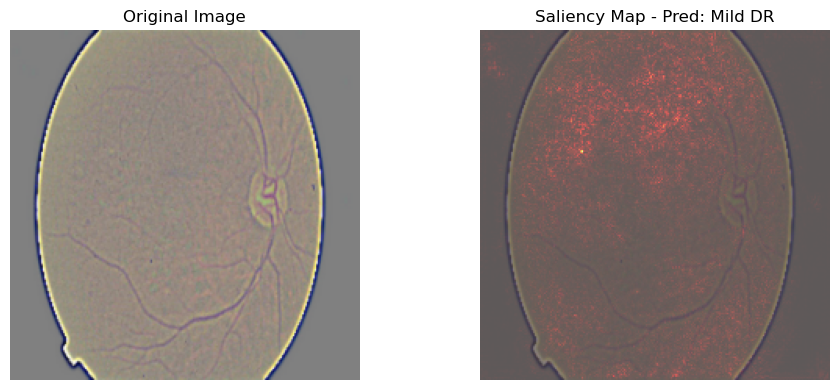

In [2]:
predict_sample(r"C:\Users\vishal kumar\Desktop\dataset\diabetic retinopathy\Moderate DR\Moderate_DR_11.png")